In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF
from sklearn.utils.multiclass import unique_labels

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import chi2_contingency

pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [2]:
imagepath = Path('../images')
datapath = Path('../data')
labs = 'labels_lower.csv'
full = 'cleaned_full_1.csv'
survey = 'features_not_scaled.csv'

In [3]:
full_df = pd.read_csv(datapath/full)
feat_df = pd.read_csv(datapath/survey)
label_df = pd.read_csv(datapath/labs)

# Final process:
1. Hold out a section from the the features df
2. Fit NMF and get top questions
3. Plot dendogram
4. Get hierarchical clusters
5. Create DF with target counts for each cluster
6. Add chi2 p-value for each cluster

In [4]:
def get_question_text(colname, label_df=label_df):
    '''
    Get column description from label_df.
    
    Parameters
    ----------
    colname : str 
        Name of column in full_df
    label_df : pd.DataFrame
        DF containing full text descriptions
        of each column in full_df
        
    Returns
    -------
    str
        Full text from original survey
        
    '''
    
    cond = label_df['Variable Name'] == colname
    idx = label_df.index[cond].tolist()[0]
    text = label_df.iloc[idx]['Question text']
    
    return text

In [5]:
def nmf_results(df, n_topics=7, top_ques=10, verbose=False): 
    '''
    Scale data in DF, fit NMF from sklearn, create W matrix, get top 
    questions/features from DF and print if verbose.
    
    Parameters
    ----------
    df : pd.DataFrame 
        Full DF containing features for model
    n_topics : int
        Number of components to pass to NMF
    top_ques : int
        Number of questions to return
    verbose : bool
        Print out questions
        
    Returns
    -------
    Sklearn NMF object
        Fitted on data in
    np.array
        W matrix
    list
        list of lists of tuples (score, column name, question)
        for each topic
        
    '''
    
    X = MinMaxScaler().fit_transform(df)  
    
    nmf = NMF(n_components=n_topics, random_state=0,
              alpha=.3, l1_ratio=.5).fit(X)

    # W matrix maps each row (person) from input matrix to topic vector -> shape(m, n_topics)
    W = nmf.transform(X)

    # For each row/person, grab the column indices with highest values
    # top_3_per_person = W.argsort()[:,-3:][:,::-1]

    # topics is the H matrix, mapping each topic to feature (question) -> shape (n_topics, p)
    topics = nmf.components_
    
    topic_questions = []
    
    for i, topic in enumerate(topics):
        topidxs = np.argsort(topic)[::-1][:top_ques]
        toplist = [(round(topic[i], 2), colname, get_question_text(colname)) 
                   for i, colname in zip(topidxs, df.columns[topidxs])]
        to_string = ['{} -> {} -> {}'.format(*tup) for tup in toplist]
        topques = '\n'.join(to_string)
        topic_questions.append(toplist)
        if verbose:
            print(f'*****Topic: {i}*****\n**Top Questions:\n{topques}\n')
        
    return nmf, W, topic_questions

In [6]:
def h_cluster(W, thresh=8, save=True):
    '''
    Create labels from hierarchical clustering and plot.
    
    Parameters
    ----------
    W : np.array 
        W matrix from NMF
    thresh : int
        threshold for dendogram/clustering
    save : bool
        Save the dendogram plot
        
    Returns
    -------
    array
        Labels from clustering
        
    '''
    
    X = MinMaxScaler().fit_transform(W)
    Z = linkage(X, method='ward')

    fig, ax = plt.subplots(figsize=(16,7))
    dn = dendrogram(Z, color_threshold=thresh, no_labels=True, ax=ax)
    ax.set_ylabel('Distance')
    ax.set_xlabel('People')
    ax.set_title(f'Hierarchical Clustering on W matrix with {W.shape[1]} topics')
    if save:
        plt.savefig(imagepath/f'dendo_{W.shape[1]}_topics.png', dpi=300)
    
    labels = fcluster(Z, t=thresh, criterion='distance')
    
    return labels

In [7]:
def chi2_to_df(df, u_labels):
    '''
    Add p values from chi2 to DF, based on labels
    
    Parameters
    ----------
    df : pd.DataFrame 
        First col is cluster number
        Col 2-4 are category counts
    u_labels : list
        list of the unique labels from clustering
        
    Returns
    -------
    pd.DataFrame
        With new columns appended for chi2 p-values
        
    '''
    
    for label in u_labels:
        to_col = []
        # Cx is counts from each category of first cluster
        Cx = df[df.cluster==label].iloc[:,1:4].values
        
        for c in u_labels:
            # Cy is counts from each category of comparing cluster
            Cy = df[df.cluster==c].iloc[:,1:4].values
            
            chi2, p, ddof, expected = chi2_contingency([Cx,Cy])
            to_col.append(round(p, 2))
        
        df[f'vs {label}'] = to_col
            
    return df

In [8]:
def total(feat_df, full_df, n_topics=7, thresh=8, holdout='swb'):
    '''
    Full process of fitting NMF, printing the top questions,
    clustering based on the W matrix, creating new DF with 
    counts of holdout category for each cluster, and adding the
    chi2 score to the DF.
    
    Parameters
    ----------
    feat_df : pd.DataFrame 
        Contains features for fitting model
    full_df : pd.DataFrame 
        Contains extra cols, such as target
    n_topics : int
        Number of topics to pass to NMF
    thresh : int
        Threshold to pass to h_cluster
    holdout : str
        Prefix to the columns to be withheld from fitting
        and used for categorical counts
        
    Returns
    -------
    pd.DataFrame
        Containing categorical counts and chi2 p-values
    array
        Labels from HAC
        
    '''
    
    keep = [c for c in feat_df.columns if holdout not in c]
    target = holdout + '_target'

    nmf, W, topic_questions = nmf_results(feat_df[keep], 
                                          n_topics=n_topics, 
                                          top_ques=10, 
                                          verbose=True)

    labels = h_cluster(W, thresh=thresh)

    u_labels, count = np.unique(labels, return_counts=True)

    target_df = pd.DataFrame()

    for label in u_labels:
        cond = (labels == label)
        s = full_df.loc[cond,:][target].value_counts().sort_index()
        target_df = target_df.append(s, ignore_index=True)
    
    target_df.insert(0, 'cluster', u_labels)
    target_df.fillna(0, inplace=True)
    target_df = chi2_to_df(target_df, u_labels)

    return target_df, labels

# Execution

*****Topic: 0*****
**Top Questions:
2.54 -> belong_1 -> If other people don't seem to accept me, I don't let it bother me.
2.42 -> moa2#2_1 -> Make independent decisions
2.26 -> efficacy_4 -> I am confident that I could deal efficiently with unexpected events.
2.26 -> efficacy_5 -> Thanks to my resourcefulness, I know how to handle unforeseen situations.
2.24 -> efficacy_6 -> I can solve most problems if I invest the necessary effort.
2.23 -> efficacy_10 -> I can usually handle whatever comes my way.
2.23 -> belong_7 -> Being apart from my friends for long periods of time does not bother me.
2.23 -> moa2#1_1 -> Make independent decisions
2.22 -> efficacy_7 -> I can remain calm when facing difficulties because I can rely on my coping abilities.
2.21 -> efficacy_1 -> I can always manage to solve difficult problems if I try hard enough.

*****Topic: 1*****
**Top Questions:
3.32 -> mindful_12 -> I drive places on â€˜automatic pilotâ€™ and then wonder why I went there.
3.13 -> mindful_7 -> 

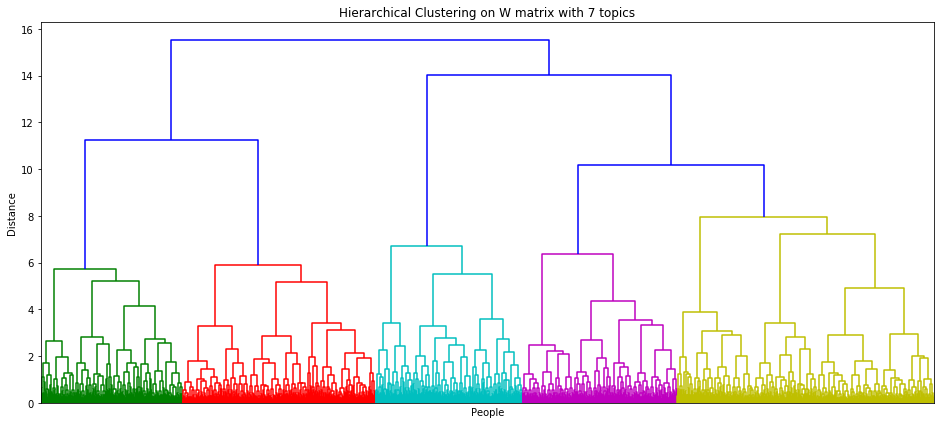

In [9]:
swb_df, labels = total(feat_df, full_df, n_topics=7, thresh=8, holdout='swb')

In [10]:
swb_df

,cluster,high,low,neutral,vs 1,vs 2,vs 3,vs 4,vs 5
0,1,155.0,72.0,221.0,1.0,0.00,0.00,0.00,0.00
1,2,330.0,22.0,260.0,0.0,1.00,0.41,0.00,0.00
2,3,266.0,12.0,186.0,0.0,0.41,1.00,0.00,0.00
3,4,211.0,38.0,241.0,0.0,0.00,0.00,1.00,0.38
4,5,348.0,81.0,383.0,0.0,0.00,0.00,0.38,1.00


In [11]:
plt.style.use('seaborn')
unique, counts =  np.unique(labels, return_counts=True)

In [12]:
# Add percentage of gender to DF

arr = np.zeros((len(unique),full_df.demo_sex.nunique()))

for i, cluster in enumerate(unique):
    cond = labels==cluster
    d = full_df[cond]
    s = d.demo_sex.value_counts() / len(d)
    arr[i] = s.values

sex_df =pd. DataFrame(arr, columns=['Female', 'Male','Other'])
swb_df = pd.concat([swb_df, sex_df], axis=1)


In [13]:
# Add percentage of age to DF

arr = np.zeros((len(unique),full_df.demo_age_bin.nunique(dropna=False)))

for i, cluster in enumerate(unique):
    cond = labels==cluster
    d = full_df[cond]
    s = d.demo_age_bin.value_counts(dropna=False).sort_index() / len(d)
    arr[i] = s.values

age_df =pd. DataFrame(arr, columns=['18', '19', '20', '21', '22', '23-25', '>25', 'nan'])
cols = age_df.columns.tolist()[-1:] + age_df.columns.tolist()[:-1]
age_df = age_df[cols]
swb_df = pd.concat([swb_df, age_df], axis=1)


In [14]:
# Add percentage of edu to DF

arr = np.zeros((len(unique),full_df.demo_edu.nunique(dropna=False)))

for i, cluster in enumerate(unique):
    cond = labels==cluster
    d = full_df[cond]
    s = d.demo_edu.value_counts(dropna=False).sort_index() / len(d)
    arr[i] = s.values

edu_df =pd. DataFrame(arr, columns=['No college', 'In college', 'Dropped out of college',
                                    'Complete 2 year degree', 'Complete Bachelors', 'In graduate edu',
                                    'Completed graduate'])

swb_df = pd.concat([swb_df, edu_df], axis=1)

In [15]:
swb_df

,cluster,high,low,neutral,vs 1,vs 2,vs 3,vs 4,vs 5,Female,Male,Other,nan,18,19,20,21,22,23-25,>25,No college,In college,Dropped out of college,Complete 2 year degree,Complete Bachelors,In graduate edu,Completed graduate
0,1,155.0,72.0,221.0,1.0,0.00,0.00,0.00,0.00,0.698661,0.258929,0.042411,0.339286,0.160714,0.145089,0.113839,0.104911,0.053571,0.055804,0.026786,0.024554,0.837054,0.006696,0.040179,0.035714,0.037946,0.017857
1,2,330.0,22.0,260.0,0.0,1.00,0.41,0.00,0.00,0.730392,0.263072,0.006536,0.348039,0.166667,0.181373,0.122549,0.078431,0.042484,0.042484,0.017974,0.008170,0.883987,0.001634,0.044118,0.021242,0.034314,0.006536
2,3,266.0,12.0,186.0,0.0,0.41,1.00,0.00,0.00,0.747845,0.245690,0.006466,0.353448,0.053879,0.103448,0.079741,0.062500,0.053879,0.105603,0.187500,0.023707,0.631466,0.028017,0.101293,0.088362,0.064655,0.062500
3,4,211.0,38.0,241.0,0.0,0.00,0.00,1.00,0.38,0.748980,0.230612,0.020408,0.297959,0.181633,0.167347,0.132653,0.055102,0.073469,0.061224,0.030612,0.014286,0.838776,0.008163,0.046939,0.036735,0.044898,0.010204
4,5,348.0,81.0,383.0,0.0,0.00,0.00,0.38,1.00,0.769704,0.221675,0.008621,0.277094,0.203202,0.168719,0.135468,0.083744,0.044335,0.061576,0.025862,0.014778,0.866995,0.006158,0.045567,0.033251,0.029557,0.003695


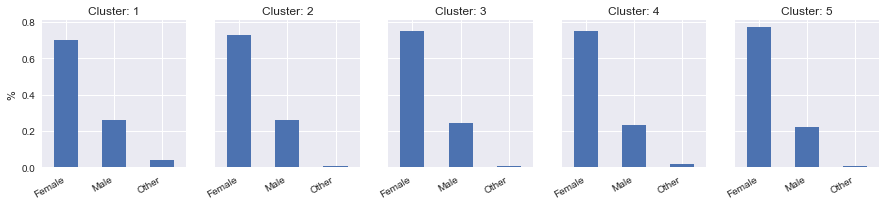

In [18]:

fig, axes = plt.subplots(1,len(unique), figsize=(15,3), sharey=True)

for i, ax in enumerate(axes.flatten()):
    ax = swb_df.loc[i, ['Female', 'Male','Other']].plot(kind='bar', ax=ax)
    ax.set_title(f'Cluster: {i+1}')
    ax.set_ylabel('%')

fig.autofmt_xdate()
plt.savefig(imagepath/'swb_sex_dist.png', dpi=300)

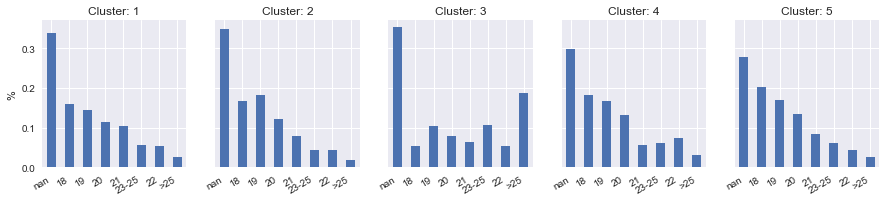

In [19]:

fig, axes = plt.subplots(1,len(unique), figsize=(15,3), sharey=True)

for i, ax in enumerate(axes.flatten()):
    ax = swb_df.loc[i, ['nan','18', '19', '20', '21', '23-25', '22',  '>25' ]].plot(kind='bar', ax=ax)
    ax.set_title(f'Cluster: {i+1}')
    ax.set_ylabel('%')

fig.autofmt_xdate()
plt.savefig(imagepath/'swb_age_dist.png', dpi=300)

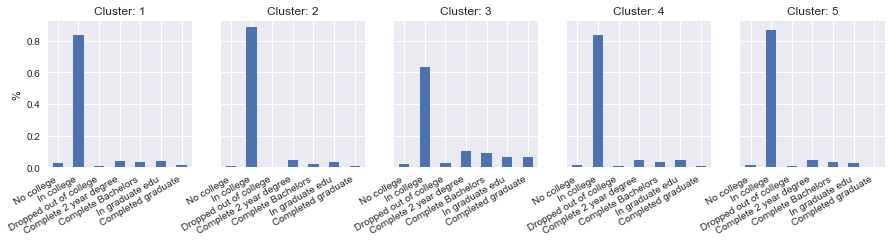

In [21]:
fig, axes = plt.subplots(1,len(unique), figsize=(15,3), sharey=True)

for i, ax in enumerate(axes.flatten()):
    ax = swb_df.loc[i, ['No college', 'In college', 'Dropped out of college',
                        'Complete 2 year degree', 'Complete Bachelors', 'In graduate edu',
                        'Completed graduate']
                   ].plot(kind='bar', ax=ax)
    ax.set_title(f'Cluster: {i+1}')
    ax.set_ylabel('%')

fig.autofmt_xdate()
plt.savefig(imagepath/'swb_edu_dist.png', dpi=300)